# Random Forests

#### Random Forests uses many decision trees and a voting strategy to determine a label of a given sample.

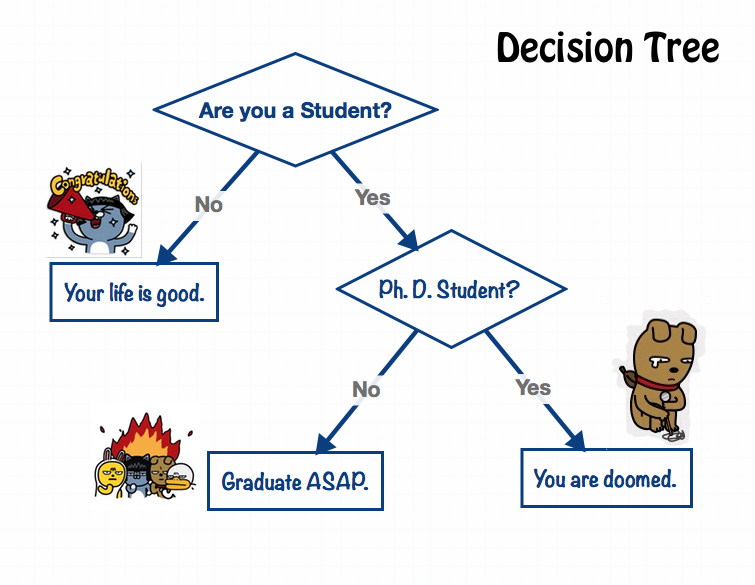

In [16]:
from IPython.display import Image
Image('Decision Tree.png')

# Read Data

In [17]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [18]:
# Read data 
data = pd.read_csv('MACHO.dat', sep='\s+')

In [19]:
# Check data
data.describe()

,amplitude,hl_amp_ratio,kurtosis,n_points,period,period_SNR,period_log10FAP,period_uncertainty,phase_cusum,phase_eta,...,quartile31,r21,r31,shapiro_w,skewness,slope_per10,slope_per90,stetson_k,weighted_mean,weighted_std
count,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,...,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000
mean,0.374743,1.278772,0.601082,1105.452381,259.901270,145.409212,-93.545090,158.954379,0.297667,1.193895,...,0.314641,0.321933,0.178168,0.951227,0.304295,-20.719353,21.433714,0.686798,-6.400083,0.201249
std,1.947101,0.892956,2.176752,176.834483,868.008429,53.837606,57.089398,650.549732,0.165909,0.658080,...,0.335230,0.200751,0.148840,0.063619,0.627605,89.222443,94.842225,0.073111,1.288285,0.156081
min,0.008500,0.299500,-1.493100,240.000000,0.138772,12.645500,-249.395500,0.000008,0.087900,0.014400,...,0.022200,0.004500,0.003400,0.500200,-1.041900,-1987.062700,0.004500,0.342700,-10.138100,0.029700
25%,0.080375,0.706750,-0.382100,1098.000000,0.603340,104.218475,-121.713325,0.000162,0.208875,0.730250,...,0.125750,0.137575,0.067500,0.936525,-0.085925,-5.873050,0.027150,0.643350,-7.360750,0.094600
50%,0.158350,1.037150,-0.023100,1146.000000,3.275996,152.228000,-85.138500,0.004584,0.267350,1.159700,...,0.246500,0.341800,0.146300,0.974450,0.156700,-0.419700,0.419450,0.705900,-6.577350,0.167850
75%,0.260225,1.492275,0.762650,1200.000000,170.957002,185.894675,-48.362725,12.238816,0.336975,1.617650,...,0.395250,0.449700,0.245825,0.989300,0.562625,-0.026450,5.749275,0.738575,-5.102025,0.255350
max,35.833600,6.683300,24.195100,1556.000000,8201.409201,240.837600,-0.548200,3695.006471,1.668400,5.043000,...,3.069700,1.004400,1.697700,0.998700,4.306500,-0.006100,2019.811600,0.853500,-3.693500,1.327100


# Check Data

In [20]:
# Get features and labels
train_featues = ['amplitude', 'hl_amp_ratio', 'kurtosis', 'period',
    'phase_cusum', 'phase_eta', 'phi21', 'phi31', 'quartile31', 
    'r21', 'r31', 'shapiro_w', 'skewness', 'slope_per10', 'slope_per90', 'stetson_k']
features = data[train_featues]

labels = data['class']
labels.value_counts()

LPV        336
RR         270
EB         189
Cepheid     75
Quasar      54
Name: class, dtype: int64

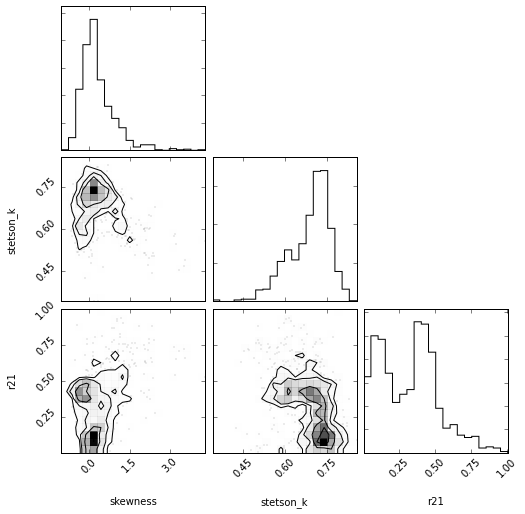

In [21]:
# Check features by plotting
import corner
check_feature = ['skewness', 'stetson_k', 'r21']
fig = corner.corner(features[check_feature], labels=check_feature)

# Train a Model Using Cross-Validation and Grid-Search

In [22]:
# Python scikit-learn
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.cross_validation import train_test_split

In [23]:
# Split data into train and test set.
X_train, X_test, y_train, y_test = \
    train_test_split(features, labels, random_state=1024, test_size=0.5)

# Parameters set
tuned_parameters = [{'n_estimators': [10, 20], 'max_features': [3, 5]}]

# Tunning hyper parameters using grid-search and cross-validation
score = 'f1_weighted'
print '# Tunning hyper-parameters for %s' % score
clf = GridSearchCV(
    RandomForestClassifier(n_jobs=4, random_state=1024, class_weight='auto'),
    tuned_parameters, cv=2, scoring=score, refit=True)
clf.fit(X_train, y_train)

print '# Done.'

# Tunning hyper-parameters for f1_weighted
# Done.


In [24]:
print '# Best parameters set found on development set:'
print clf.best_params_

print '# Grid scores on development set:'
for params, mean_score, scores in clf.grid_scores_:
    print ' %0.3f (+/-%0.03f) for %r' \
        % (mean_score, scores.std() * 2, params)

# Best parameters set found on development set:
{'max_features': 5, 'n_estimators': 20}
# Grid scores on development set:
 0.917 (+/-0.019) for {'max_features': 3, 'n_estimators': 10}
 0.939 (+/-0.017) for {'max_features': 3, 'n_estimators': 20}
 0.937 (+/-0.013) for {'max_features': 5, 'n_estimators': 10}
 0.939 (+/-0.017) for {'max_features': 5, 'n_estimators': 20}


# Predict

In [25]:
# Predict using the test set.
y_true, y_pred = y_test, clf.predict(X_test)
print train_featues
print clf.best_estimator_.feature_importances_

print
print classification_report(y_test.tolist(), y_pred.tolist(),
    labels=np.unique(y_test))

['amplitude', 'hl_amp_ratio', 'kurtosis', 'period', 'phase_cusum', 'phase_eta', 'phi21', 'phi31', 'quartile31', 'r21', 'r31', 'shapiro_w', 'skewness', 'slope_per10', 'slope_per90', 'stetson_k']
[ 0.00357564  0.08244245  0.05500851  0.24626127  0.00698717  0.11776554
  0.00295621  0.00248454  0.02545287  0.01364257  0.01799247  0.0250789
  0.07349834  0.14646163  0.15624482  0.02414708]

             precision    recall  f1-score   support

    Cepheid       1.00      1.00      1.00        40
         EB       0.91      0.95      0.93       101
        LPV       0.94      0.99      0.97       154
     Quasar       0.90      0.73      0.81        26
         RR       0.98      0.93      0.95       141

avg / total       0.95      0.95      0.95       462



# Confusion matrix
['Cepheid', 'EB', 'LPV', 'Quasar', 'RR']
[[ 40   0   0   0   0]
 [  0  96   2   0   3]
 [  0   0 152   2   0]
 [  0   0   7  19   0]
 [  0  10   0   0 131]]


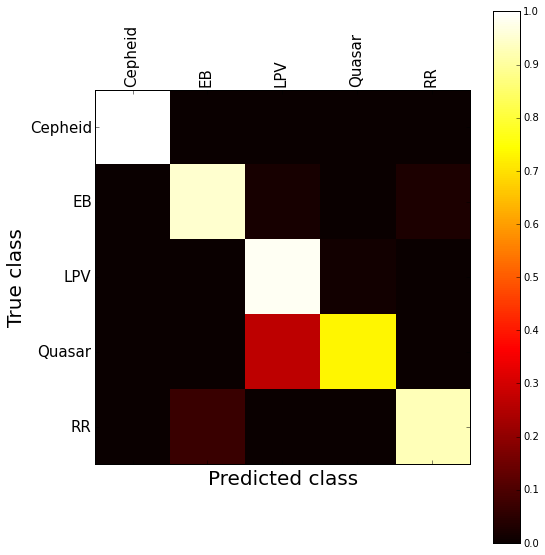

In [26]:
unique_label = np.unique(y_test).tolist()

# Print and plot confusion matrix
cm = confusion_matrix(y_test.tolist(), y_pred.tolist(),
    labels=np.unique(y_test))
cm_unity = (1.0*cm.T / np.sum(cm, axis=1)).T

print '# Confusion matrix'
print unique_label
print cm

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
cax = ax.matshow(cm_unity, cmap='hot')
fig.colorbar(cax)
plt.ylabel('True class', fontsize=20)
plt.xlabel('Predicted class', fontsize=20)

ax.set_xticks(np.arange(len(unique_label)))
ax.set_yticks(np.arange(len(unique_label)))
unique_label_replaced = [ele.replace('_', ' ') for ele in unique_label]
ax.set_xticklabels(unique_label_replaced, rotation=90., fontsize=15)
ax.set_yticklabels(unique_label_replaced, fontsize=15)
plt.tight_layout()

# Feature Importance

[-1, 18, 0, 0.25]

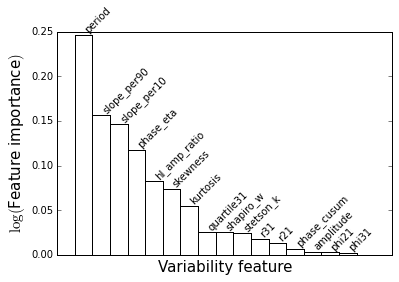

In [27]:
# Plot feature importance.
width = 1.0
importance = clf.best_estimator_.feature_importances_
sorted_index = np.argsort(importance)[::-1]
x = np.arange(len(train_featues))
plt.bar(x, importance[sorted_index], width=width, color='w')
plt.xlabel('Variability feature', fontsize=15)
plt.ylabel('$\log($Feature importance$)$', fontsize=15)
plt.xticks([])
plt.xticks([])

# label

sorted_feature = np.array(train_featues)[sorted_index]
for i in range(len(sorted_feature)):
    fontsize = 10
    plt.text(i + width / 2., importance[sorted_index][i], sorted_feature[i],
        rotation=45, va='bottom', fontsize=fontsize)
plt.axis([-1, 18, 0, 0.25])

# Save the Model

In [28]:
# Save model.
# Note: We're saving a model trained only with the half dataset.
#In principle, you need to train a new model using the whole set and the best parameters determined above.
import gzip
import cPickle as pickle
pickle.dump(clf, gzip.open('rf.model.gz', 'wb'), protocol=2)